In [1]:
import keras
import segmentation_models as sm
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

Segmentation Models: using `keras` framework.


# Parameter

In [2]:
IMAGE_SIZE = (256,256,3)

path_base_model = './models/'
path_base_input = './samples/'

# Model loads

In [5]:
BACKBONE = 'efficientnetb0'
model1 = sm.Unet(BACKBONE, input_shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],IMAGE_SIZE[2]),classes=1, activation='sigmoid',encoder_weights='imagenet')
model2 = sm.Unet(BACKBONE, input_shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],IMAGE_SIZE[2]),classes=1, activation='sigmoid',encoder_weights='imagenet')
model3 = sm.Unet(BACKBONE, input_shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],IMAGE_SIZE[2]),classes=1, activation='sigmoid',encoder_weights='imagenet')

BACKBONE = 'efficientnetb7'
model4 = sm.Unet(BACKBONE, input_shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],IMAGE_SIZE[2]),classes=1, activation='sigmoid',encoder_weights='imagenet')
model5 = sm.Unet(BACKBONE, input_shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],IMAGE_SIZE[2]),classes=1, activation='sigmoid',encoder_weights='imagenet')

preprocess_input = sm.get_preprocessing(BACKBONE)

model1.load_weights(path_base_model + 'model1.hdf5')
model2.load_weights(path_base_model + 'model2.hdf5')
model3.load_weights(path_base_model + 'model3.hdf5')
model4.load_weights(path_base_model + 'model4.hdf5')
model5.load_weights(path_base_model + 'model5.hdf5')

# Functions

In [6]:
def preprocessing_HE(img_):
    
    hist, bins = np.histogram(img_.flatten(), 256,[0,256])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')

    img_2 = cdf[img_]
    
    return img_2  
        
def get_binary_mask (mask_, th_ = 0.5):
    mask_[mask_>th_]  = 1
    mask_[mask_<=th_] = 0
    return mask_
    
def ensemble_results (mask1_, mask2_, mask3_, mask4_, mask5_):
    
    mask1_ = get_binary_mask (mask1_)
    mask2_ = get_binary_mask (mask2_)
    mask3_ = get_binary_mask (mask3_)
    mask4_ = get_binary_mask (mask4_)
    mask5_ = get_binary_mask (mask5_)
    
    ensemble_mask = mask1_ + mask2_ + mask3_ + mask4_ + mask5_
    ensemble_mask[ensemble_mask<=2.0] = 0
    ensemble_mask[ensemble_mask> 2.0] = 1
    
    return ensemble_mask

def postprocessing_HoleFilling (mask_):
    
    ensemble_mask_post_temp = ndimage.binary_fill_holes(mask_).astype(int)
     
    return ensemble_mask_post_temp

def get_maximum_index (labeled_array):
    
    ind_nums = []
    for i in range (len(np.unique(labeled_array)) - 1):
        ind_nums.append ([0, i+1])
        
    for i in range (1, len(np.unique(labeled_array))):
        ind_nums[i-1][0] = len(np.where (labeled_array == np.unique(labeled_array)[i])[0])
        
    ind_nums = sorted(ind_nums)
    
    return ind_nums[len(ind_nums)-1][1], ind_nums[len(ind_nums)-2][1]
    
def postprocessing_EliminatingIsolation (ensemble_mask_post_temp):
        
    labeled_array, num_features = label(ensemble_mask_post_temp)
    
    ind_max1, ind_max2 = get_maximum_index (labeled_array)
    
    ensemble_mask_post_temp2 = np.zeros (ensemble_mask_post_temp.shape)
    ensemble_mask_post_temp2[labeled_array == ind_max1] = 1
    ensemble_mask_post_temp2[labeled_array == ind_max2] = 1    
    
    return ensemble_mask_post_temp2.astype(int)

def get_prediction(model_, img_org_):
    
    img_org_resize = cv2.resize(img_org_,(IMAGE_SIZE[0],IMAGE_SIZE[1]),cv2.INTER_AREA)
    img_org_resize_HE = preprocessing_HE (img_org_resize)    
    img_ready = preprocess_input (img_org_resize_HE)

    img_ready = np.expand_dims(img_ready, axis=0) 
    pr_mask = model_.predict(img_ready)
    pr_mask = np.squeeze(pr_mask)
    pr_mask = np.expand_dims(pr_mask, axis=-1)    
    return pr_mask[:,:,0]

# Inference

file:  sample00.png


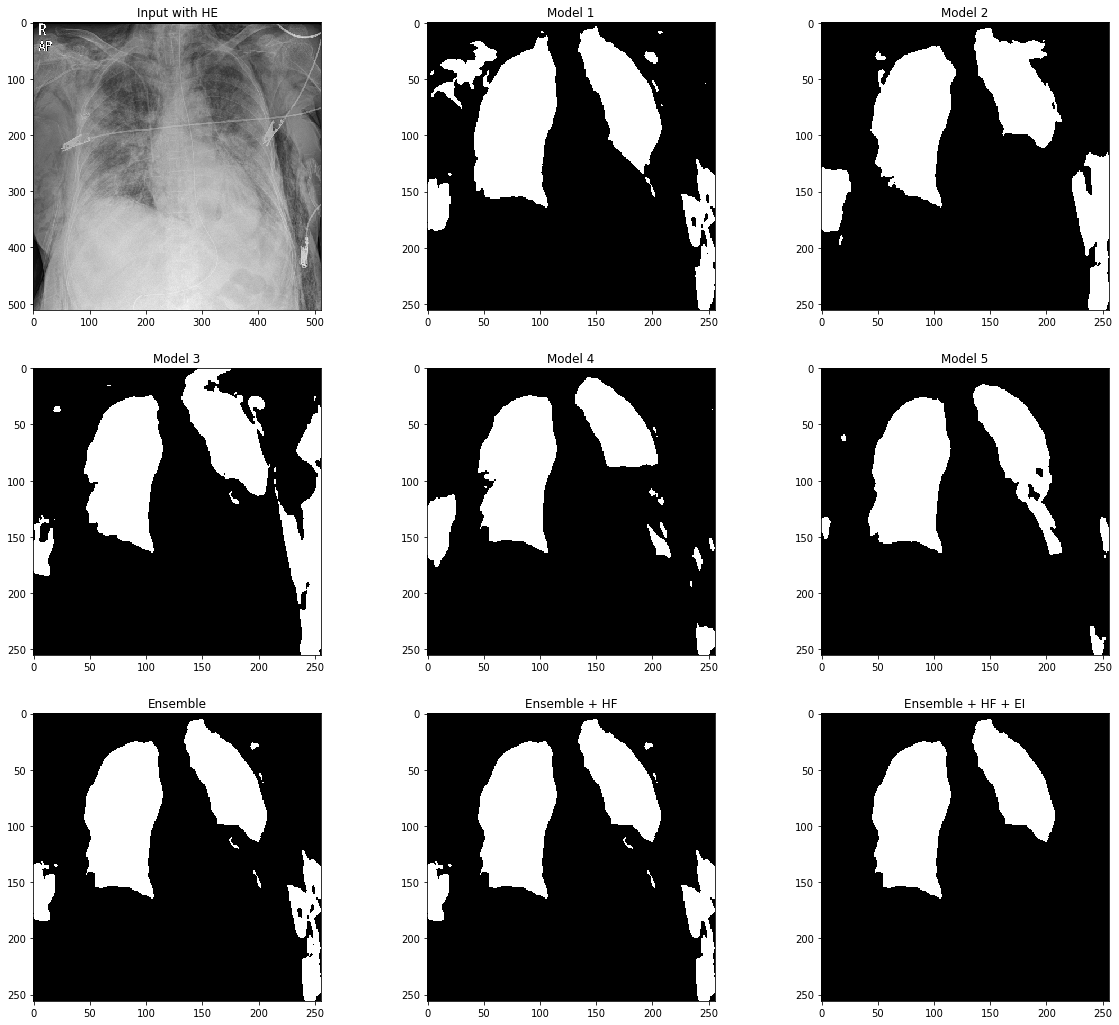

file:  sample01.png


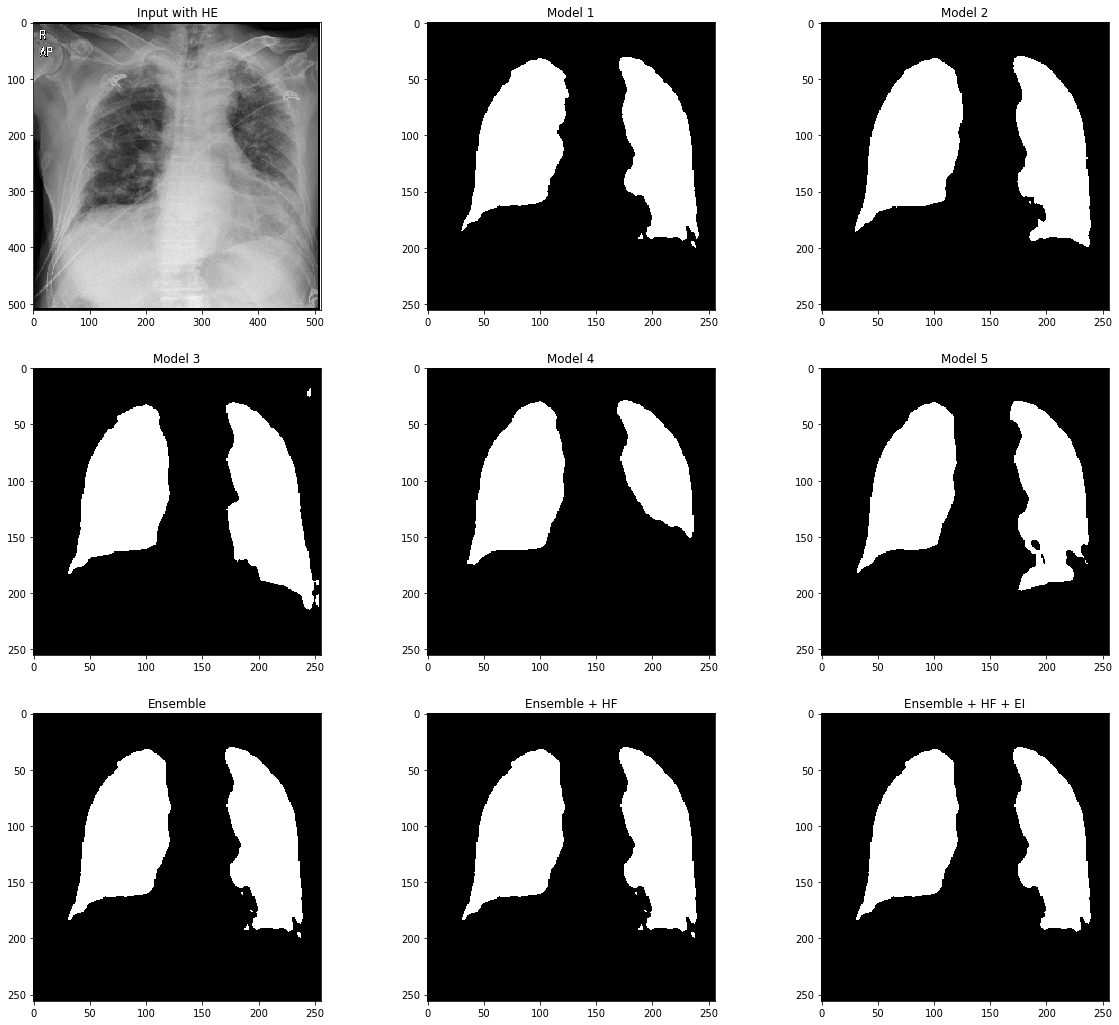

file:  sample02.png


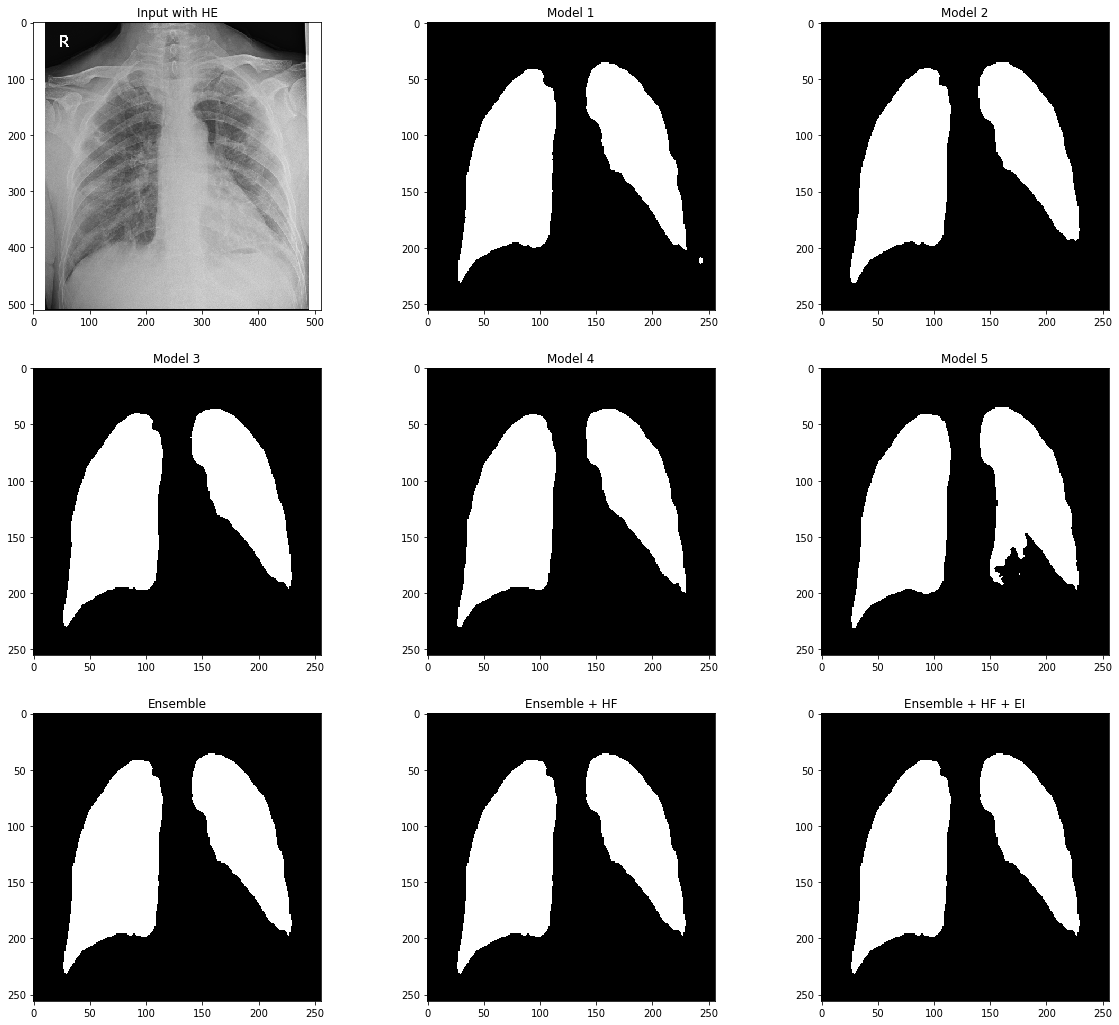

file:  sample03.png


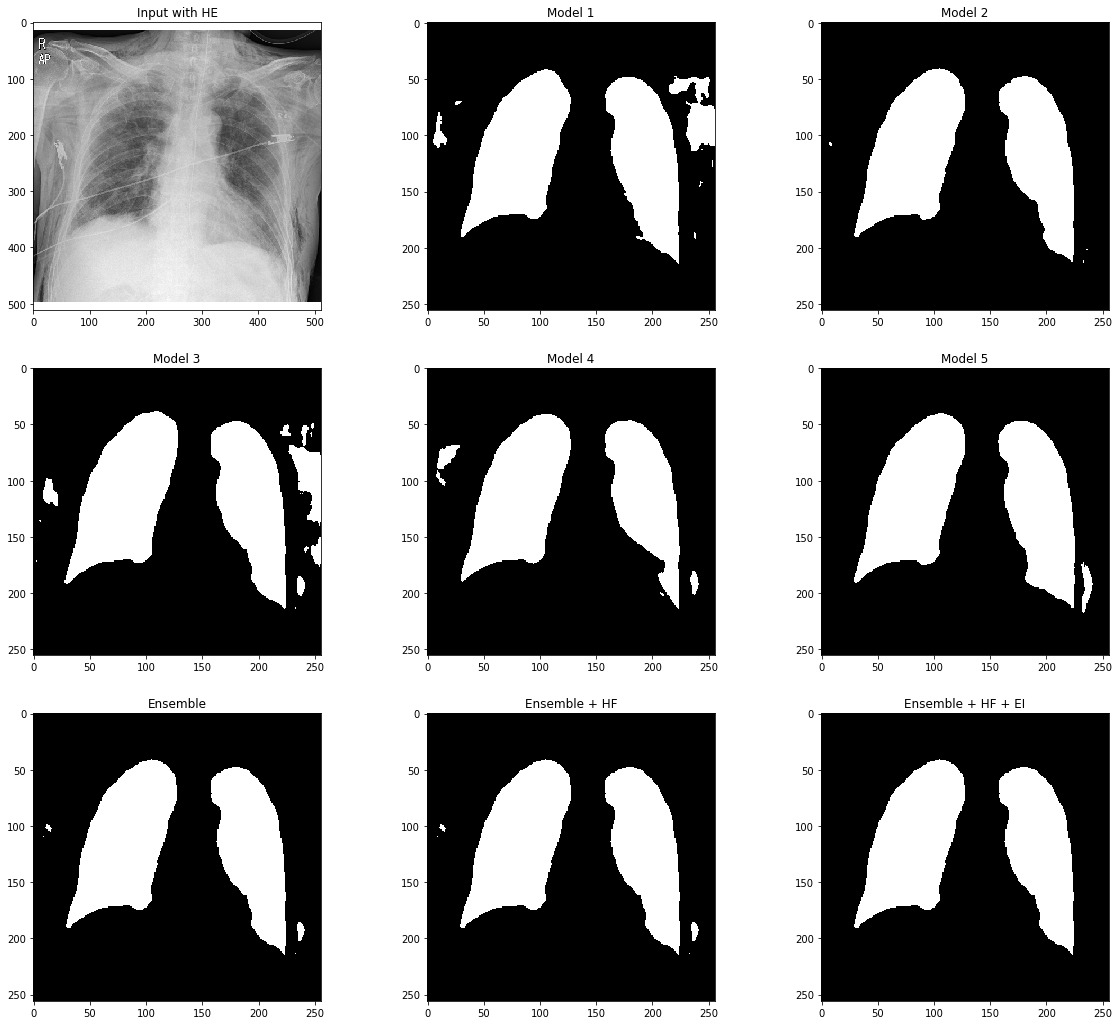

file:  sample04.png


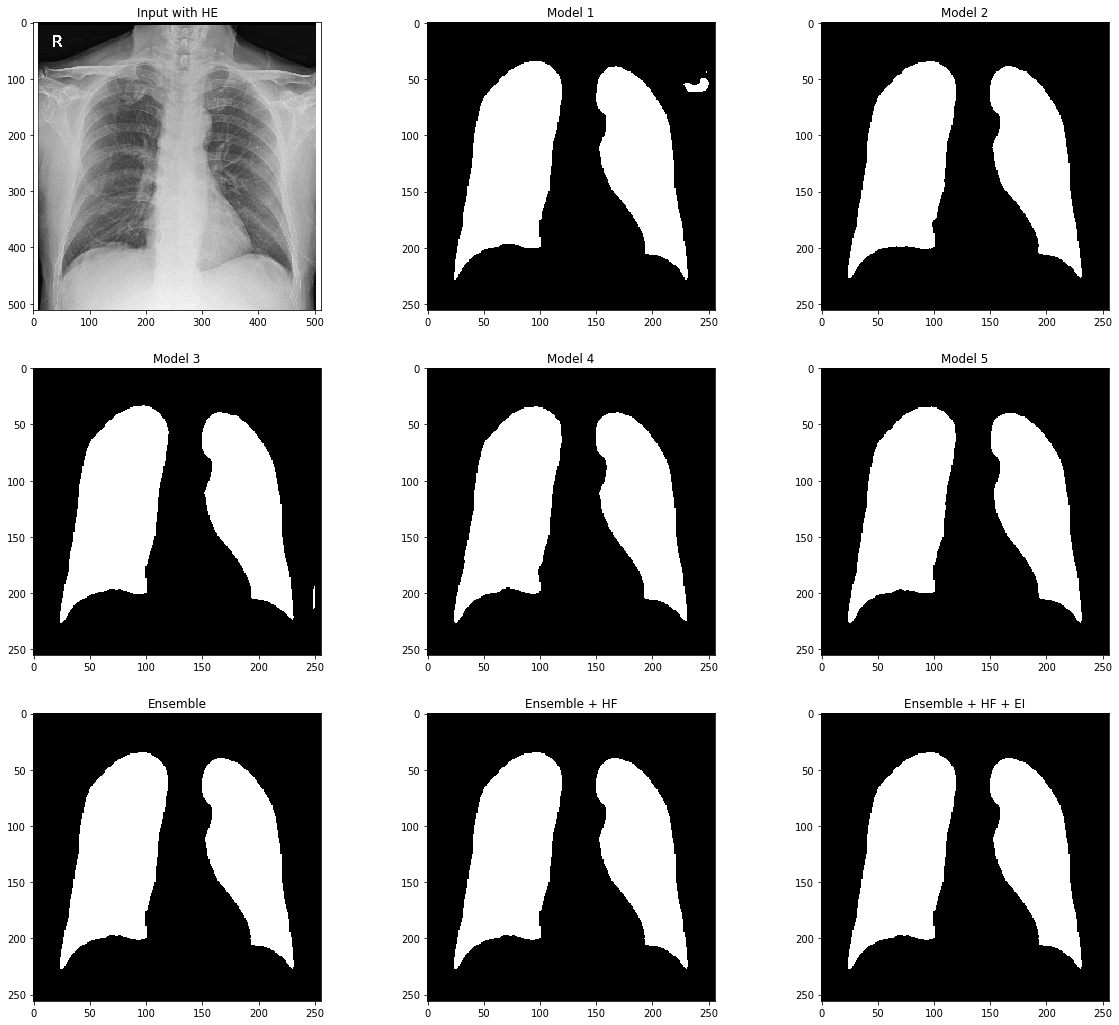

file:  sample05.png


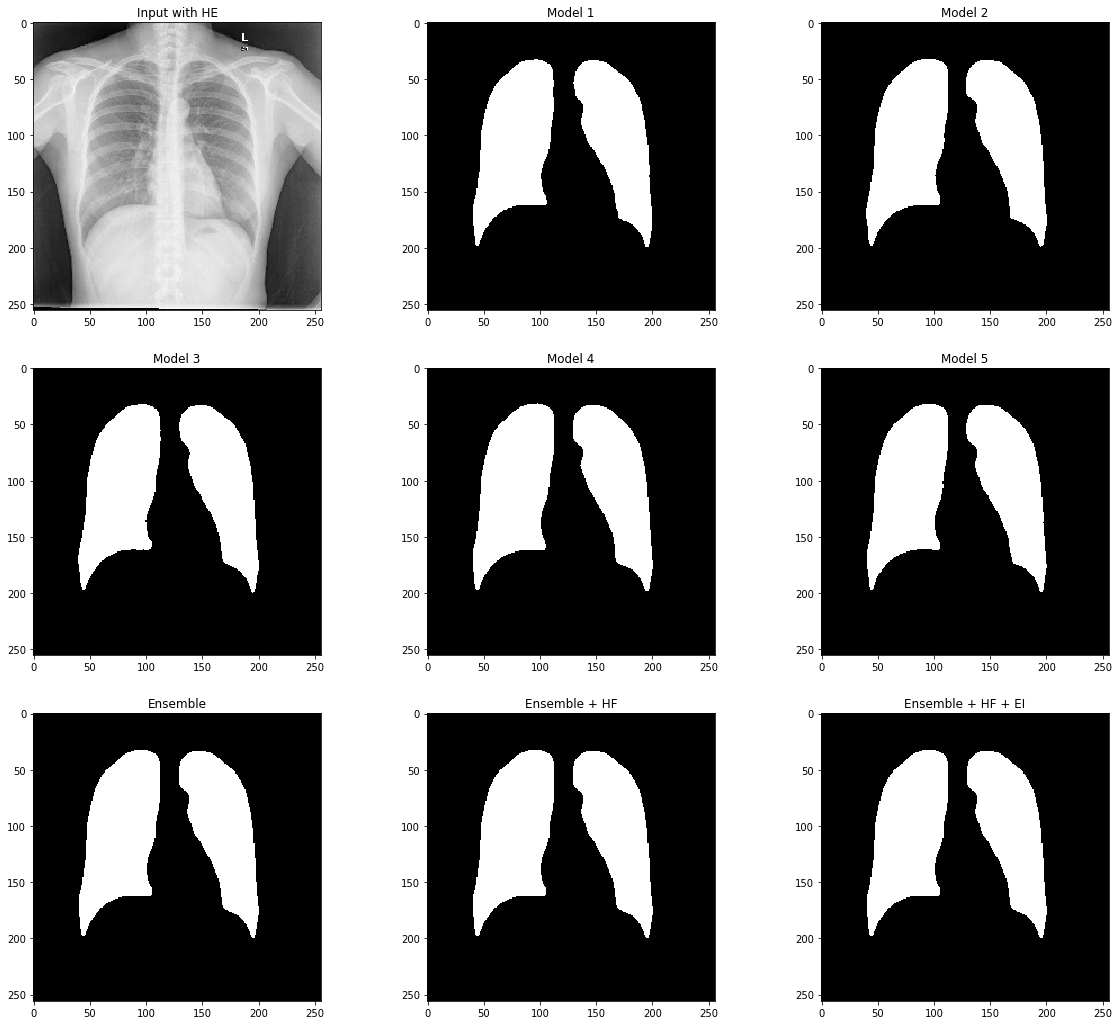

file:  sample06.png


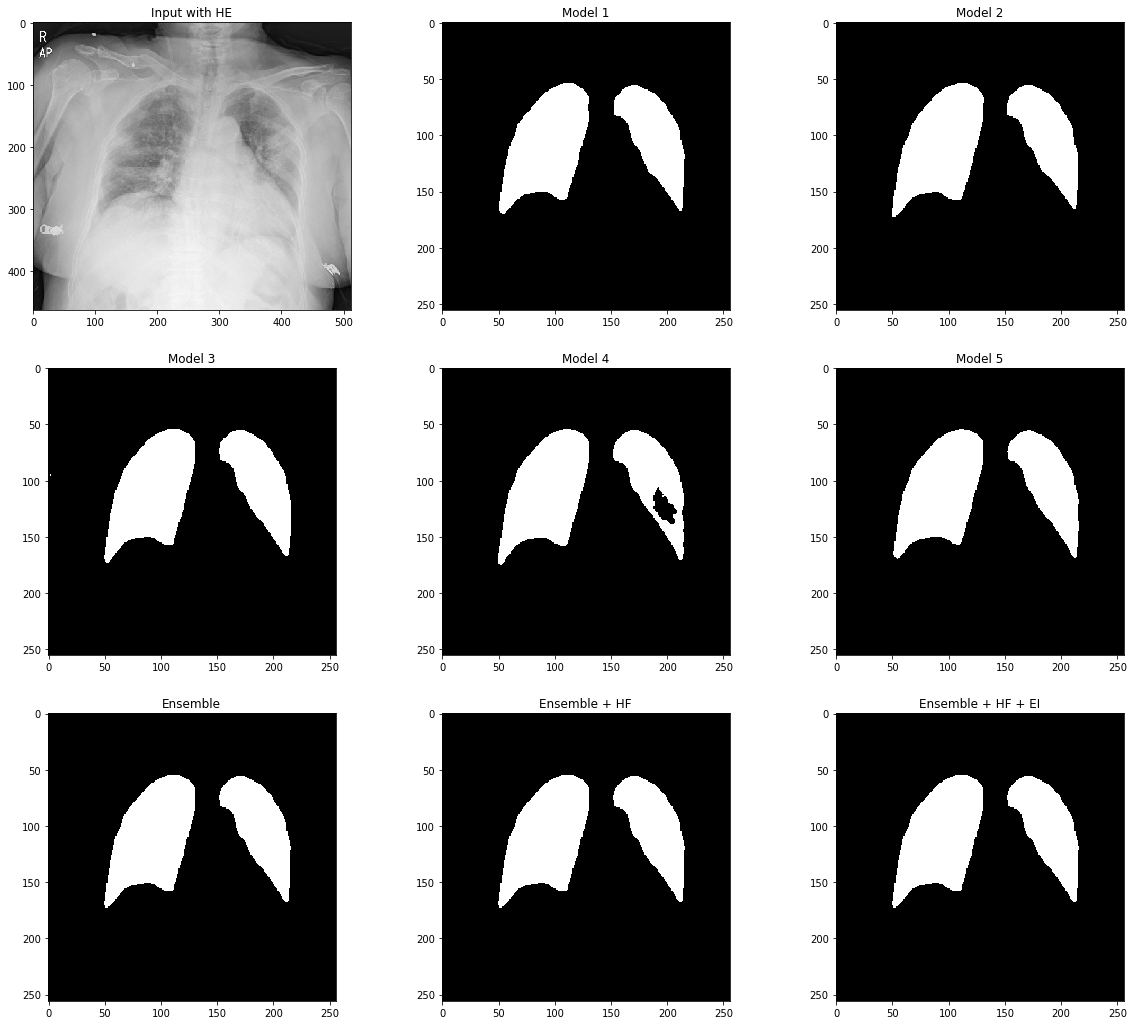

file:  sample07.png


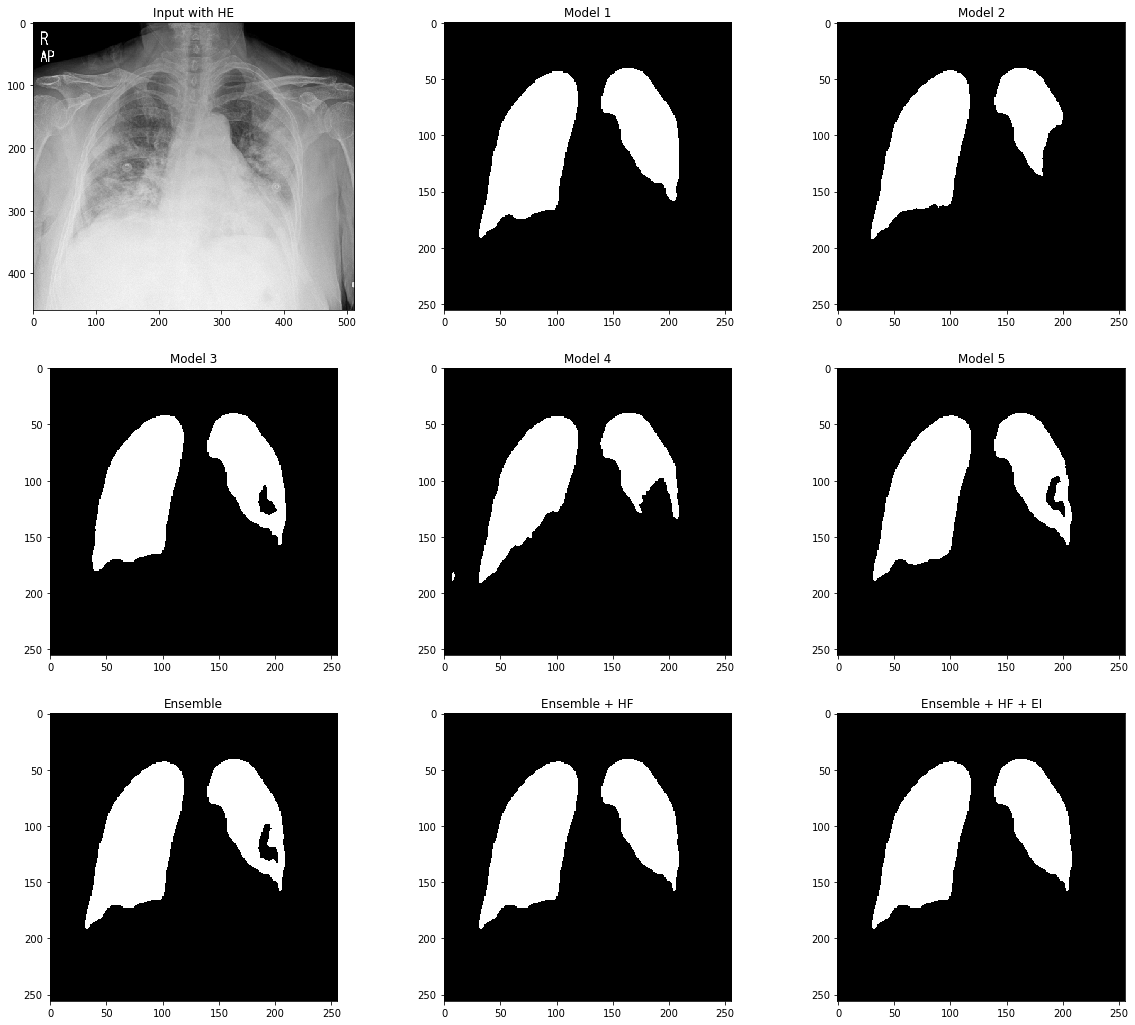

file:  sample08.png


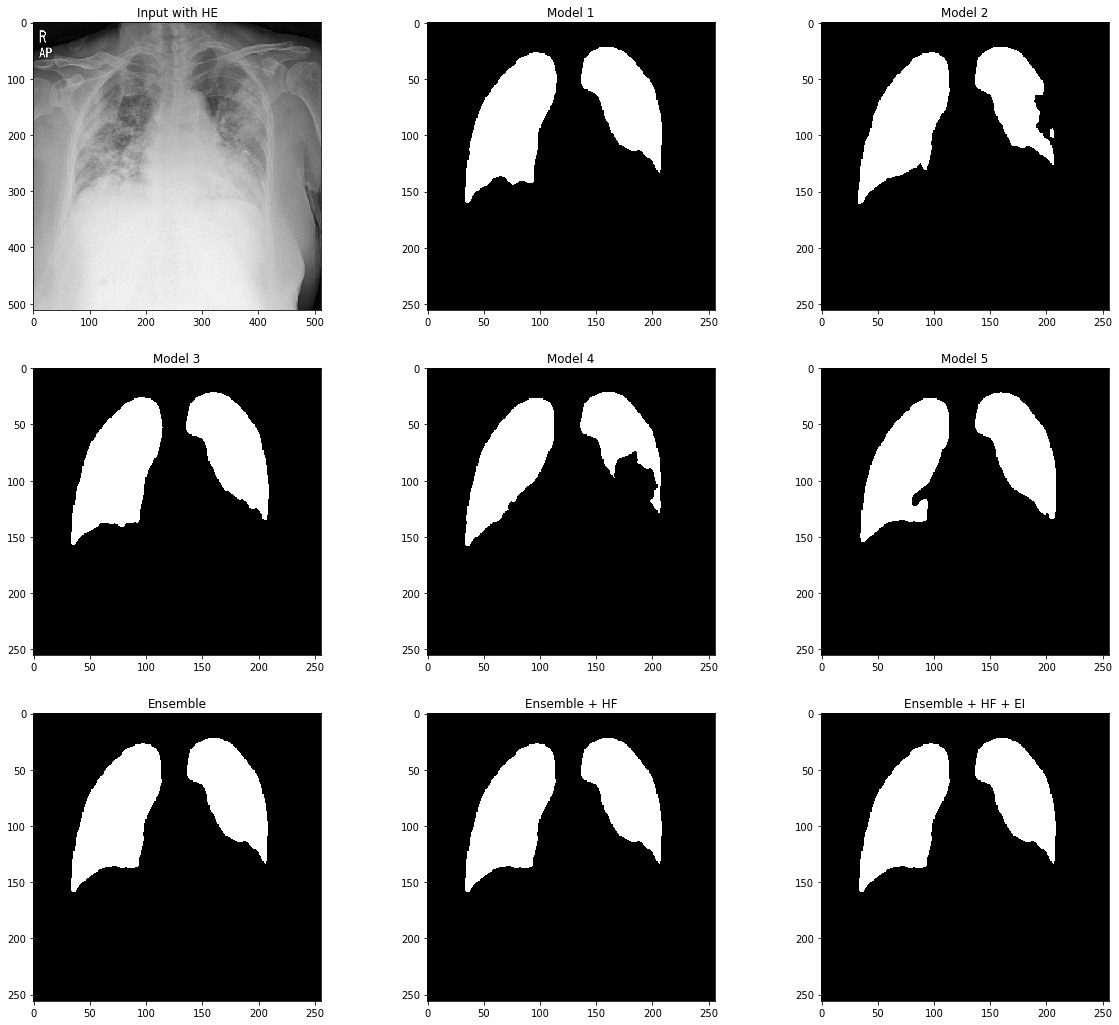

file:  sample09.png


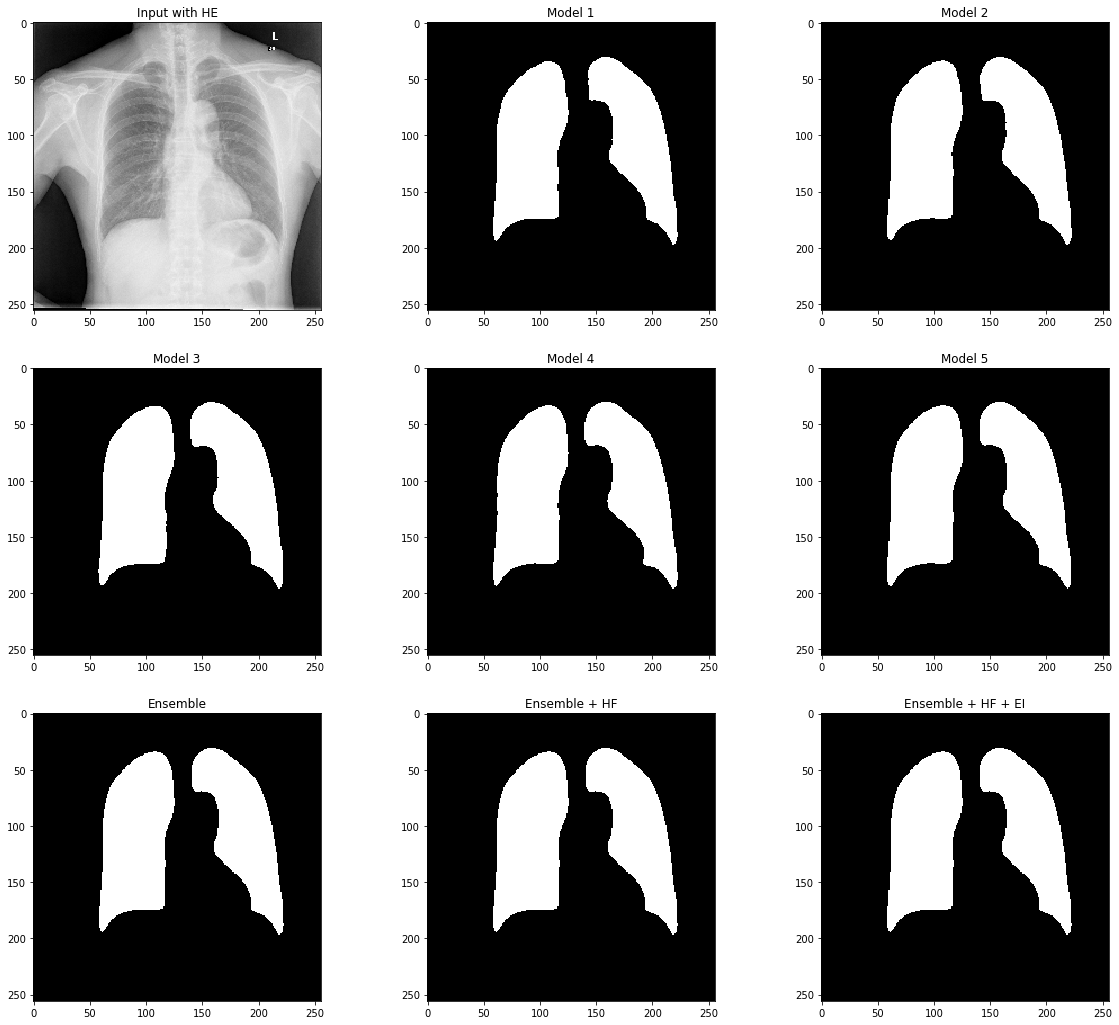

In [11]:
for path_ in sorted(glob.glob (path_base_input + '*.*')):

    print ('file: ', path_.split('/')[-1])
    
    img = cv2.imread(path_)    
    pr_mask1 = get_prediction (model1, img)
    pr_mask2 = get_prediction (model2, img)
    pr_mask3 = get_prediction (model3, img)
    pr_mask4 = get_prediction (model4, img)
    pr_mask5 = get_prediction (model5, img)    
    
    ensemble_mask            = ensemble_results (pr_mask1, pr_mask2, pr_mask3, pr_mask4, pr_mask5)
    ensemble_mask_post_HF    = postprocessing_HoleFilling (ensemble_mask)
    ensemble_mask_post_HF_EI = postprocessing_EliminatingIsolation (ensemble_mask_post_HF)

    plt.figure(figsize=(20, 18))
    plt.subplot(3, 3, 1)
    plt.title('Input with HE')
    plt.imshow(img)
    plt.subplot(3, 3, 2)
    plt.title('Model 1')
    plt.imshow(pr_mask1, cmap='gray')
    plt.subplot(3, 3, 3)
    plt.title('Model 2')
    plt.imshow(pr_mask2, cmap='gray')
    plt.subplot(3, 3, 4)
    plt.title('Model 3')
    plt.imshow(pr_mask3, cmap='gray')
    plt.subplot(3, 3, 5)
    plt.title('Model 4')
    plt.imshow(pr_mask4, cmap='gray')
    plt.subplot(3, 3, 6)
    plt.title('Model 5')
    plt.imshow(pr_mask5, cmap='gray')
    plt.subplot(3, 3, 7)
    plt.title('Ensemble')
    plt.imshow(ensemble_mask, cmap='gray')
    plt.subplot(3, 3, 8)
    plt.title('Ensemble + HF')
    plt.imshow(ensemble_mask_post_HF, cmap='gray')
    plt.subplot(3, 3, 9)
    plt.title('Ensemble + HF + EI')
    plt.imshow(ensemble_mask_post_HF_EI, cmap='gray')
    plt.show()